<a href="https://colab.research.google.com/github/MaximeGloesener/HandsOnAI-Challenge1/blob/master/1-DataCleaning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1. Importation des librairies**

In [ ]:
!/opt/bin/nvidia-smi
!rm -rf sample_data

In [ ]:
!pip install ImageHash

In [ ]:
import os
import cv2
from PIL import Image
from google.colab import files
import imagehash
import matplotlib.pyplot as plt

#**2. Téléchargement des données d'entraînement et de test**

In [ ]:
bases_path_after="bases"
test="test_data"
if not os.path.exists(bases_path_after):
    os.makedirs(bases_path_after)
if not os.path.exists(test):
  os.makedirs(test)

In [ ]:
!rm -rf FIRE_DATABASE_1.tar
!rm -rf sample_data
!wget https://cluster.ig.umons.ac.be/HackIA21/databases/FIRE_DATABASE_1.tar
!tar xf FIRE_DATABASE_1.tar -C 'bases' --one-top-level
!rm FIRE_DATABASE_1.tar

In [ ]:
!rm -rf FIRE_DATABASE_2.tar
!rm -rf sample_data
!wget https://cluster.ig.umons.ac.be/HackIA21/databases/FIRE_DATABASE_2.tar
!tar xf FIRE_DATABASE_2.tar -C 'bases' --one-top-level
!rm FIRE_DATABASE_2.tar

In [ ]:
!rm -rf FIRE_DATABASE_3.tar
!rm -rf sample_data
!wget https://cluster.ig.umons.ac.be/HackIA21/databases/FIRE_DATABASE_3.tar
!tar xf FIRE_DATABASE_3.tar -C 'bases' --one-top-level
!rm FIRE_DATABASE_3.tar

In [ ]:
# Données de test
!rm -rf sample_data
!wget --no-check-certificate http://195.154.53.219/downloads/test.tar
! tar xf test.tar -C 'test_data' --one-top-level
! rm test.tar

# **3. Analyse des données**

In [ ]:
def read_image(file_name):
  """
  Fonction qui prend en entrée une path d'image et qui convertit l'image en RGB (utile pour plot avec matplotlib)
  """
  img = cv2.imread(file_name, 3)
  b,g,r = cv2.split(img)
  rgb_image = cv2.merge([r,g,b])
  return rgb_image

In [ ]:
# Analyse des images dans un directory: 
# -> permet d'identifier les problèmes dans le dataset (images aberrantes / présence de doublons)
directory = 'bases/test/start_fire'

for index, img in enumerate(os.listdir(directory)):
  img = os.path.join(os.getcwd(), directory, img)
  fig = plt.figure()
  image = read_image(img)
  plt.imshow(image)
  plt.title(img)

# **4. Identification des doublons**

In [ ]:
def plot(images, noms):
  """
  Fonction utilisée pour afficher les doublons côte à côte 
  Permet de tester différent hash et de choisir la méthode de hachage avec le moins de faux positifs
  """
  f, axarr = plt.subplots(1,len(images))
  for i in range(len(images)):
    axarr[i].imshow(images[i])
    axarr[i].title.set_text(noms[i])


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 20 bytes but only got 19. Skipping tag 36867
  " Skipping tag %s" % (size, len(data), tag)


DATASET 1 
Il y a 205 doublons dans le dataset = 13.666666666666666% des données
DATASET 2 
Il y a 1426 doublons dans le dataset = 95.06666666666666% des données
DATASET 3 
Il y a 20 doublons dans le dataset = 1.3333333333333335% des données


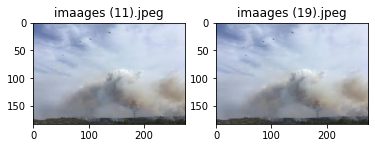

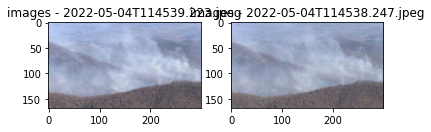

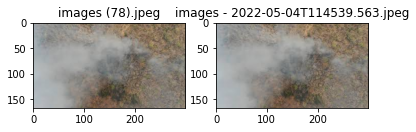

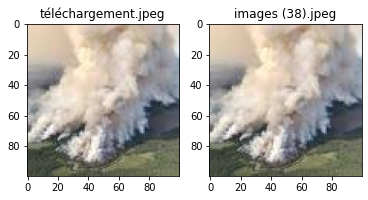

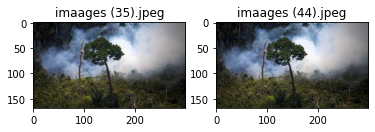

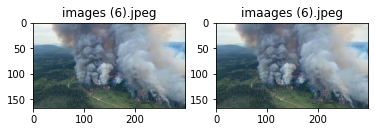

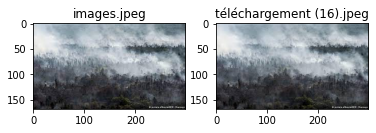

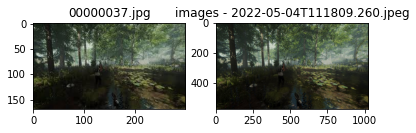

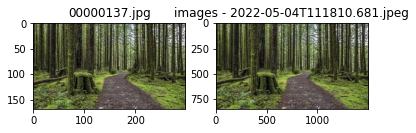

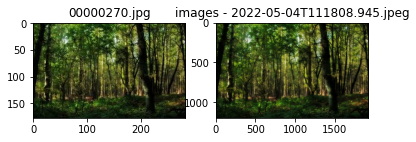

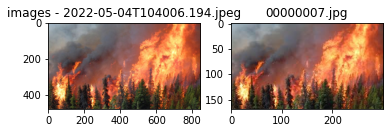

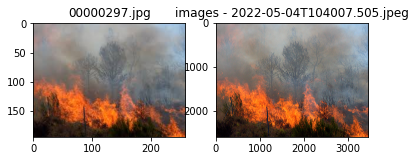

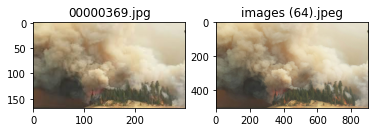

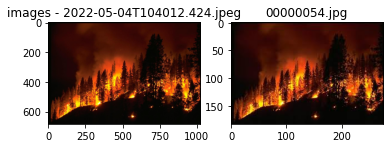

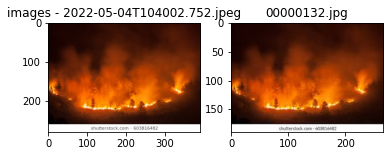

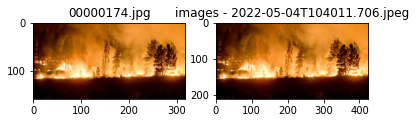

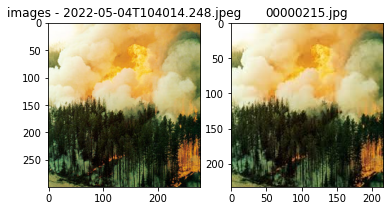

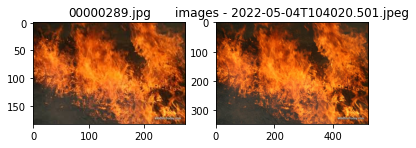

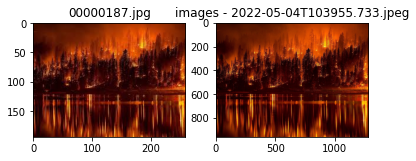

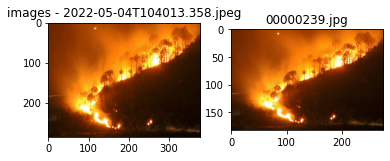

In [16]:
# On a pu identifier la présence de doublons dans les jeux de données
# But : analyser chaque dataset et trouver le nombre d'images en doublons
def analyse_dataset(folder_name, affichage = False):
  """
  Fonction qui prend en entrée le directory d'un dataset et qui va chercher les images qui sont présentes plusieurs fois pour ce même dataset
  Affichage = True si on veut plot les images qui sont en doubles et leur nom
  Return: - le nombre de doublons dans un dataset
          - le pourcentage de doublons
  """
  img_hashes = dict()
  total = 0
  doublons = 0

  for dir in os.listdir(folder_name):
    for image in os.listdir(os.path.join(folder_name, dir)):
      total += 1
      image = os.path.join(os.getcwd(), folder_name, dir, image)
      hash = imagehash.dhash(Image.open(image))
      if hash in img_hashes:
        doublons += 1
        #print(f'{image} doublons de {img_hashes[hash]}')
        if affichage:
          i = read_image(image) 
          x = read_image(img_hashes[hash])
          plot([x,i],[image.split("/")[-1], img_hashes[hash].split("/")[-1]])
      else:
        img_hashes[hash] = image

  return doublons, doublons/total*100

d1, p1 = analyse_dataset("/content/bases/FIRE_DATABASE_1/")
d2, p2 = analyse_dataset("/content/bases/FIRE_DATABASE_2/")
d3, p3 = analyse_dataset("/content/bases/FIRE_DATABASE_3/", affichage = True)
print('DATASET 1 ')
print(f'Il y a {d1} doublons dans le dataset = {p1}% des données')
print('DATASET 2 ')
print(f'Il y a {d2} doublons dans le dataset = {p2}% des données')
print('DATASET 3 ')
print(f'Il y a {d3} doublons dans le dataset = {p3}% des données')


# **5. Création d'un seul dataset sans doublon**

In [ ]:
# Créer un seul dataset à partir des 3 en ne prenant en compte que des images uniques (supprimer tous les doublons)
def make_dataset(base_directory):
  """
  Fonction qui va concaténer les 3 datasets de départ et créer un seul dataset sans doublons
  Return les hashs des images déjà présentes dans le dataset -> utile lors de la phase data augmentation pour 
  ne pas rajouter des images qui sont déjà présentes dans la jeu de données 
  """
  !rm -rf all_data
  directory = 'all_data'
  directory_path = os.path.join(os.getcwd(), directory)
  # créer un nouveau directory all_data s'il n'existe pas déjà
  if not os.path.exists(directory_path):
    os.mkdir(directory_path)
    os.mkdir(os.path.join(directory_path, "fire"))
    os.mkdir(os.path.join(directory_path, "no_fire"))
    os.mkdir(os.path.join(directory_path, "start_fire"))

  images_hash = set()
  for dir in os.listdir(base_directory):
    for dir2 in os.listdir(os.path.join(base_directory,dir)):
      for img in os.listdir(os.path.join(base_directory,dir,dir2)):
        path = os.path.join(os.getcwd(), base_directory, dir, dir2, img)
        hash = imagehash.dhash(Image.open(path))
        if hash not in images_hash:
          images_hash.add(hash)
          cv2.imwrite(os.path.join(directory_path, dir2, img), cv2.imread(path))
  return images_hash 
hashes = make_dataset("bases")

# **6. Stockage des hashs**

In [ ]:
# Stocker les hashs déjà présents dans notre DB d'images pour ne pas par la suite, rajouter des images déjà présentes
with open('hashes.txt','w') as fout:
  for hash in hashes:
    fout.write(f"{hash}\n")

# **7. Identification du nombre de données**

In [17]:
fire = len(os.listdir("/content/all_data/fire"))
no_fire = len(os.listdir("/content/all_data/no_fire"))
start_fire = len(os.listdir("/content/all_data/start_fire"))
print(f"Nombre d'images de la classe fire : {fire}")
print(f"Nombre d'images de la classe no fire : {no_fire}")
print(f"Nombre d'images de la classe start_fire: {start_fire}")
print(f"Nombre total d'images: {fire+start_fire+no_fire}")

Nombre d'images de la classe fire : 700
Nombre d'images de la classe no fire : 497
Nombre d'images de la classe start_fire: 492
Nombre total d'images: 1689


# **8. Stockage des données sur un drive**

In [ ]:
# Connexion au drive et copier les données et les hash sur le drive et dans le folder partagé
from google.colab import drive
drive.mount('/content/gdrive')
%cp -av "/content/all_data/" "/content/gdrive/MyDrive/Challenge1/"
%cp -av "/content/hashes.txt" "/content/gdrive/MyDrive/Challenge1/"